### Abhishek Savita GEOMAR 2023.08.28
#### Scritp to compute AMV index 

In [1]:
#Importing  important libraries those need for arthmatic calculations
import glob
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.ticker as tck
import cmocean
import matplotlib.colors as colors

In [2]:
data0hadisst   = xr.open_dataset('/data/user/asavita/data_observations/HadISST/HadISST_sst.nc')
data0hadisst    = data0hadisst.sel(time=slice('1870-01-01','2022-12-31'))#.mean('time_counter',keep_attrs=True)
data0hadisst=data0hadisst.rename({'longitude': 'lon'})
data0hadisst=data0hadisst.rename({'latitude': 'lat'})
data0hadisst=data0hadisst.rename({'time': 'time_counter'})
sst=data0hadisst['sst']
sst_1901_2005 =sst.sel(time_counter=slice('1870-01-01','2022-12-31')).mean('time_counter')

In [3]:
#detrending steps
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    detrend =  da - fit
    return detrend, fit

## Function to calculate anomaly model
def anom_mon(var):
    import warnings
    warnings.filterwarnings('ignore')
    #time1=time1
    clim1  = var.groupby('time_counter.month').mean(dim='time_counter')
    anom1  = var.groupby('time_counter.month') - clim1
    return anom1

## Function to calculate anomaly model
def anual_mean(var):
    import warnings
    warnings.filterwarnings('ignore')
    #time1=time1
    #clim1  = var.groupby('time_counter.year').mean(dim='time_counter')
    ann  = var.groupby('time_counter.year').mean(dim='time_counter')# - clim1.mean(dim='year') 
    return ann

# -- regional average if coordinates given in lat and lon format
def weighted_areaave_cordinate_short(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     lon=( (lon + 180) % 360 - 180) 
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)
  
#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  odat1=anm.sel(lat=iplat,lon=iplon)#.mean(("lon", "lat"), skipna=True)
  #odat2=anm.weighted(wgt)#.mean(("lon", "lat"), skipna=True)  
  return odat, odat1

def butter_filt(x, filt_year, fs, order_butter, idim):
    from scipy import signal
    """
    """
    fc=(1/filt_year)/2
    b, a=signal.butter(order_butter,fc,'low',fs=fs,output='ba')
    out=signal.filtfilt(b,a,x,axis=idim)
    return out

def filtfilt_butter(x, filt_year, fs, order_butter, dim='time'):
    dim_list=list(x.dims)
    idim=dim_list.index(dim)
    filt= xr.apply_ufunc(
        butter_filt,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year,  # as above
        fs,  # as above
        order_butter,  # as above
        idim, # dimension to filter along 
        input_core_dims=[list(x.dims), [], [],[], []],  # list with one entry per arg
        output_core_dims=[list(x.dims)],  # returned data has 3 dimension
        vectorize=True,  # loop over non-core dims
    )
    return filt

def line_plot41(latx1,var1,ymin,ymax,nrows,ncol,nsub,vartitle,legend1,xlabel_text,ylabel_text):
    ax=fig.add_subplot(nrows,ncol,nsub)
    ax.plot(latx1,var1,linewidth=2,color='black',label=legend1)
    ax.set_ylabel(ylabel_text,position=(0.1,0.5),fontsize=16,fontweight='bold')
    ax.set_xlabel(xlabel_text,position=(0.5,0.5),fontsize=16,fontweight='bold')
    ax.set_title(vartitle, y=1.12,pad=-20,fontsize=16,fontweight='bold')
    ax.axhline(y=0.0,color='black',linewidth=2,linestyle='dotted')
    #ax1.text(180,80,'global')
    ax.set_ylim([ymin,ymax])
    ax.set_xlim([1870,2022])
    ax.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True,size=5,width=4)
    plt.rcParams['font.size']='12'
    plt.rcParams['font.weight']='bold'
    plt.rcParams['axes.labelweight']='bold'
    #ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    #plt.suptitle('Global anual mean surface air temperature',position=(0.5,1),fontsize=20,fontweight='bold')
    #ax.legend()
    #ax.legend(loc="upper left", mode = "expand", ncol = 3)
    #ax1.text(0.3, 1.41, 'Global',fontsize=12, fontweight='bold')
    ax.grid()
    plt.tight_layout; plt.draw()

In [4]:
## MAskout data which is -1000.0 to nan
sst_masked = sst.where(sst != -1000.) #put all values -1000 to nan
# SST Montlhy anomaly
sst_mon_anm=anom_mon(sst_masked) # monthly animaly reference to 1870-2022

# Annual average
sst_ann_anm=anual_mean(sst_mon_anm)

# Latitudional weighted global average
wgt = np.cos(np.deg2rad(sst_ann_anm['lat']))
sst_ann_gave=sst_ann_anm.weighted(wgt).mean(("lon", "lat"), skipna=True)

### Method 1

In [5]:
## removing the gloval average annual sst from the sst annual anomaly at each grid point
sst_ann_rgave=sst_ann_anm-sst_ann_gave

# Steps to compute AMV index 
sst_NAave,sst_NA=weighted_areaave_cordinate_short(sst_ann_rgave,0.0,70.0,-80,0) 
sst_NAave_de,aa=detrend_dim(sst_NAave, 'year', deg=1) # remove linear trend
sst_NAave_de_filt=filtfilt_butter(sst_NAave_de,filt_year=11,fs=1,order_butter=4,dim='year')

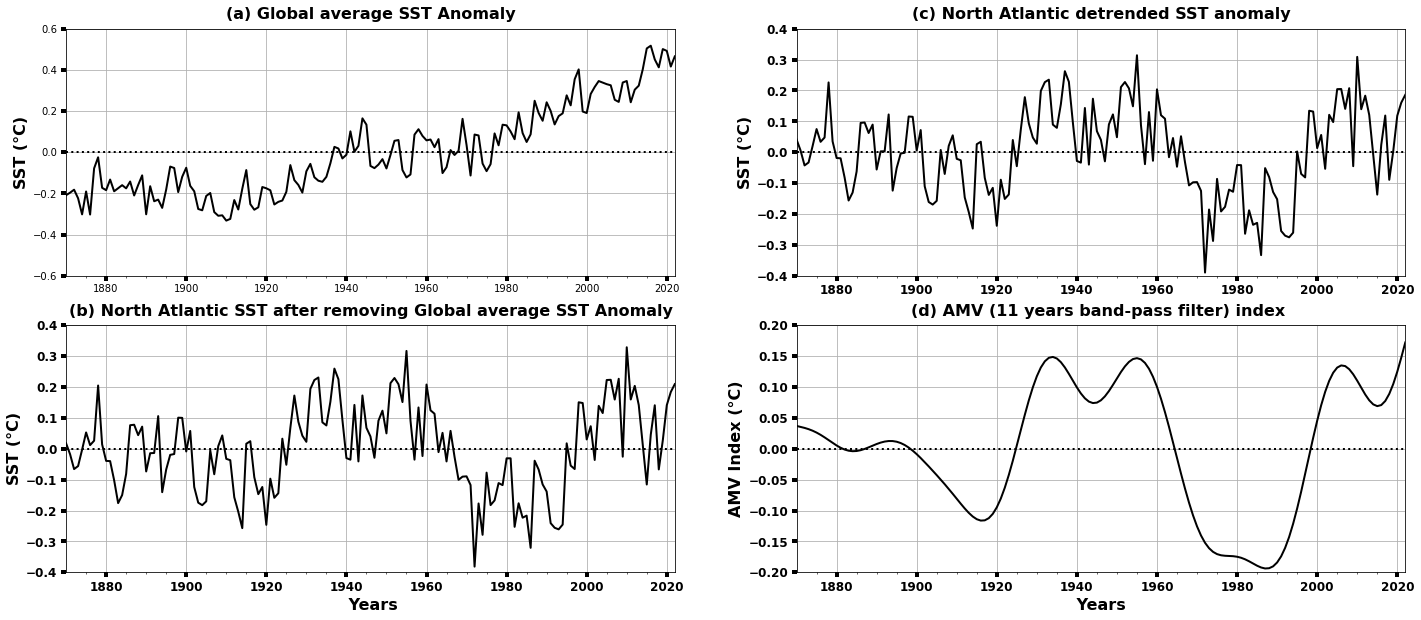

In [6]:
fig = plt.figure(figsize=[24,10])
line_plot41(sst_NAave_de['year'],sst_ann_gave,-.6,.6,2,2,1,'(a) Global average SST Anomaly',' ',' ', 'SST (\N{DEGREE SIGN}C)')
line_plot41(sst_NAave_de['year'],sst_NAave,-.4,.4,2,2,3,'(b) North Atlantic SST after removing Global average SST Anomaly',' ',' Years', 'SST (\N{DEGREE SIGN}C)')
line_plot41(sst_NAave_de_filt['year'],sst_NAave_de,-.4,.4,2,2,2,'(c) North Atlantic detrended SST anomaly',' ','   ', 'SST (\N{DEGREE SIGN}C)')
line_plot41(sst_NAave_de_filt['year'],sst_NAave_de_filt,-.2,.2,2,2,4,'(d) AMV (11 years band-pass filter) index ',' ',' Years ', 'AMV Index (\N{DEGREE SIGN}C)')


## Method 2

In [7]:
## Computing the regression line form global time series 
bb,sst_glb_best_fit=detrend_dim(sst_ann_gave,'year', deg=1) # remove linear trend

## removing best fit sst data from the sst annual anomaly at each grid point
sst_ann_rgave=sst_ann_anm-sst_glb_best_fit

# Steps to compute AMV index 
sst_NAave,sst_NA=weighted_areaave_cordinate_short(sst_ann_rgave,0.0,70.0,-80,0) 
sst_NAave_filt=filtfilt_butter(sst_NAave,filt_year=11,fs=1,order_butter=4,dim='year')

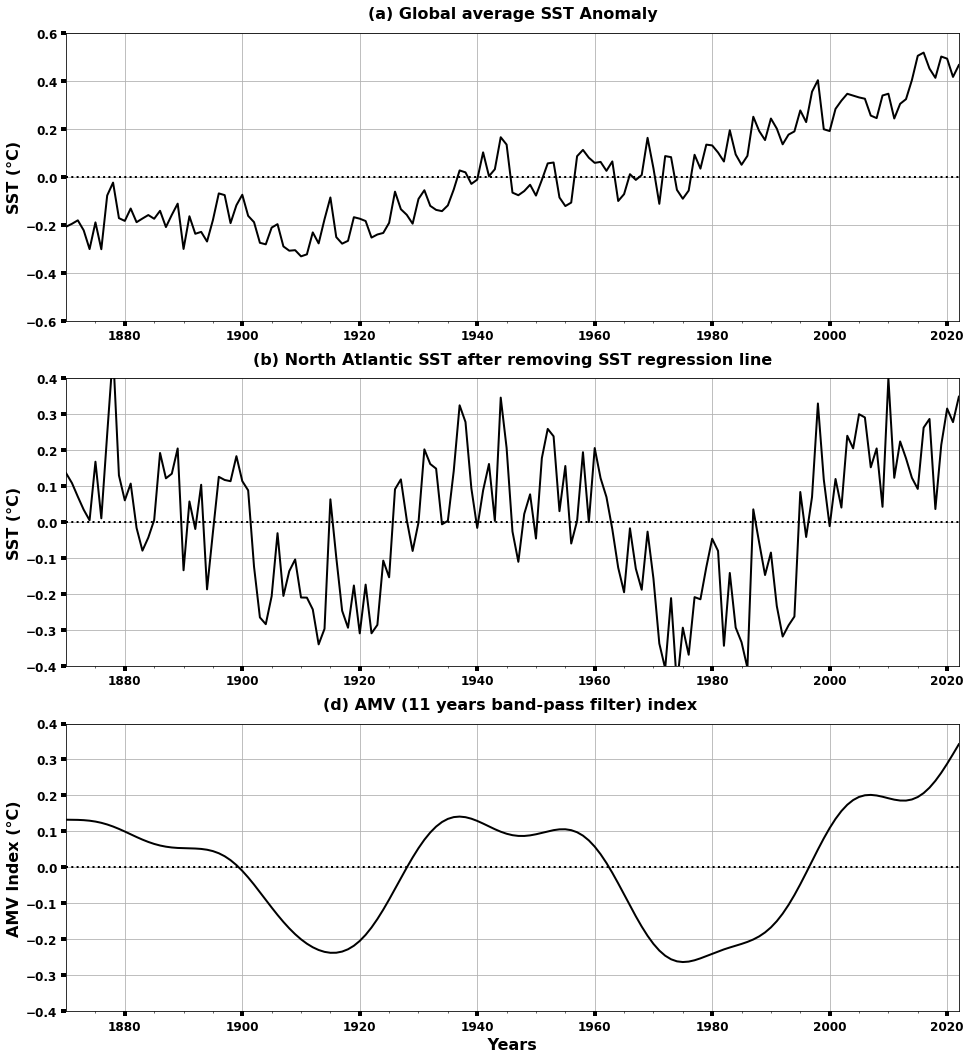

In [8]:
fig = plt.figure(figsize=[16,18])
line_plot41(sst_NAave_de['year'],sst_ann_gave,-.6,.6,3,1,1,'(a) Global average SST Anomaly',' ',' ', 'SST (\N{DEGREE SIGN}C)')
line_plot41(sst_NAave_de['year'],sst_NAave,-.4,.4,3,1,2,'(b) North Atlantic SST after removing SST regression line',' ','  ', 'SST (\N{DEGREE SIGN}C)')
line_plot41(sst_NAave_de_filt['year'],sst_NAave_filt,-.4,.4,3,1,3,'(d) AMV (11 years band-pass filter) index ',' ',' Years ', 'AMV Index (\N{DEGREE SIGN}C)')
